### Семинар 
9.05.20

План
1. librosa
2. Mel Spectrogram: STFT (Short Time Fourier Transform), Spectrogram, Mel-basis
3. Naive bio Gender Classifier
4. Spoil!



In [1]:
!pip3 install librosa

In [2]:
from sklearn.model_selection import train_test_split
from itertools import chain
from tqdm import tqdm, tqdm_notebook
import joblib as jl
import os

import matplotlib.pyplot as plt
import IPython # прослушивание аудио в ноутбуке
import numpy as np # отсюда возьмем Фурье
import librosa # множественные манипуляции с аудиофайлами 
import keras, keras.layers

%matplotlib inline

import torch
from sklearn.metrics import accuracy_score
plt.style.use('fivethirtyeight')

In [3]:
! wget https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3 -O sample_f.mp3
! wget https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3 -O sample_m.mp3

--2020-12-20 09:44:24--  https://audio-previews.elements.envatousercontent.com/files/6319559/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 65.9.73.86, 65.9.73.48, 65.9.73.35, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)|65.9.73.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28202 (28K) [audio/mpeg]
Saving to: ‘sample_f.mp3’

sample_f.mp3        100%[===================>]  27.54K  --.-KB/s    in 0s      

2020-12-20 09:44:24 (60.0 MB/s) - ‘sample_f.mp3’ saved [28202/28202]

--2020-12-20 09:44:24--  https://audio-previews.elements.envatousercontent.com/files/256324900/preview.mp3
Resolving audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercontent.com)... 65.9.73.86, 65.9.73.48, 65.9.73.35, ...
Connecting to audio-previews.elements.envatousercontent.com (audio-previews.elements.envatousercon

In [4]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [5]:
!ffmpeg -i sample_m.mp3 -ar 22050 -ac 1 sample_m.wav

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [7]:
IPython.display.Audio(librosa.load('sample_m.wav')[0], rate = 22050)

In [8]:
type(librosa.load('sample_m.wav')[0])

numpy.ndarray

https://drive.google.com/drive/folders/1fb1rFkA2vn4tOBY-5IGc85AEX_Lptk_W

In [10]:
IPython.display.Audio('sample_m.wav')

### **Часть 1**

Напоминание: файл *.wav -- набор амплитуд, отсчитываемых за определенные промежутки времени. Sample rate (sr) -- число отсчитываемых амплитуд в секунду, параметр качества записи. Построим график амплитуд:

37440 points, 1.6979591836734693 sec, sr 22050


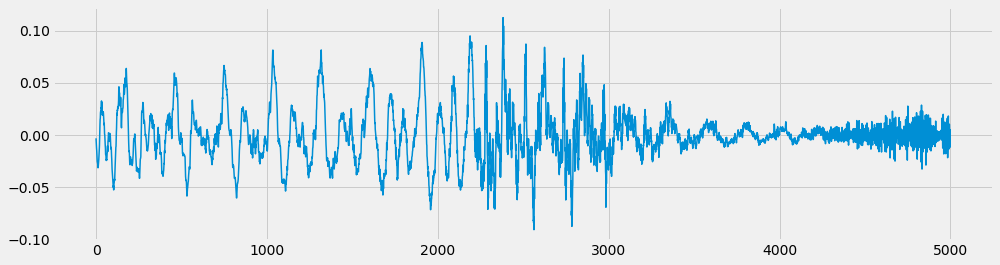

In [11]:
amplitudes, sample_rate = librosa.load("sample_m.wav")
print(f"{len(amplitudes)} points, {len(amplitudes) / sample_rate} sec, sr {sample_rate}")
plt.figure(figsize=[15, 4])
plt.title('')
plt.plot(amplitudes[20000:25000],linewidth=1.5)

In [12]:
type(amplitudes)

numpy.ndarray

В двух секундах 60000 точек! Работать неудобно, надо конвертировать в формат, с которым умеем работать (в изображение). Используем **быстрое преобразование Фурье** чтобы понять, какие же именно компоненты преобладают в некоторый момент времени. Подробнее: https://en.wikipedia.org/wiki/Short-time_Fourier_transform


<img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Spectrogram-19thC.png" width="640px">


Не забудем, что перед преобразование Фурье мы используем к фреймам по отдельности и потом склеиваем все в единую картину. Также следует помнить, что если использовать просто спектрограмму без перехода в мел-пространство, то мы можем сломать нашу будущую сетку слишком большими значениями. Подробнее: https://en.wikipedia.org/wiki/Mel-frequency_cepstrum


<img src="https://labrosa.ee.columbia.edu/doc/HTKBook21/img165.gif" width="640px">

**Алгоритм построения мел-спектрограммы по набору частот:**
1. Разделяем вход на пересекающиеся фреймы
2. Применяем к каждому преобразование Фурье
3. Переводим полученную спектрограмму в мел-пространство

In [13]:
def slice_into_frames(amplitudes, window_length, hop_length):
    return librosa.core.spectrum.util.frame(
        np.pad(amplitudes, int(window_length // 2), mode='reflect'),
        frame_length=window_length, hop_length=hop_length)
    # выход: [window_length, num_windows]

In [14]:
def get_STFT(amplitudes, window_length, hop_length):
    """ Compute short-time Fourier Transform """
    # разбиваем амплитуды на пересекающиеся фреймы [window_length, num_frames]
    frames = slice_into_frames(amplitudes, window_length, hop_length)
    
    # получаем веса для Фурье, float[window_length]
    fft_weights = librosa.core.spectrum.get_window('hann', window_length, fftbins=True)
    
    # применяем преобразование Фурье
    stft = np.fft.rfft(frames * fft_weights[:, None], axis=0)
    return stft

In [15]:
def get_melspectrogram(amplitudes, sample_rate=22050, n_mels=128,
                       window_length=2048, hop_length=512, fmin=1, fmax=8192):
    """
    Implement mel-spectrogram as described above.
    :param amplitudes: float [num_amplitudes]
    :param sample rate: число отсчетов каждую секунду
    :param n_mels: число каналов спектрограммы
    :param window_length: параметр размера окна для Фурье
    :param hop_length: размер пересечения 
    :param f_min: мин частота
    :param f_max: макс частота
    :returns: мел-scaled спектрограмма [n_mels, duration]
    """
    # Шаг 1
    stft = get_STFT(amplitudes, window_length, hop_length)
    assert stft.shape == (window_length // 2 + 1, len(amplitudes) // 512 + 1)
    
    # Шаг 2
    spectrogram = np.abs(stft ** 2)
    
    # Шаг 3
    mel_basis = librosa.filters.mel(sample_rate, n_fft=window_length,
                                    n_mels=n_mels, fmin=fmin, fmax=fmax)
    # ^-- matrix [n_mels, window_length / 2 + 1]
    
    mel_spectrogram = np.dot(mel_basis, spectrogram)
    assert mel_spectrogram.shape == (n_mels, len(amplitudes) // 512 + 1)
    
    return mel_spectrogram

In [17]:
amplitudes1, _  = librosa.load('sample_m.wav')
amplitudes2, _  = librosa.load('sample_f.mp3')

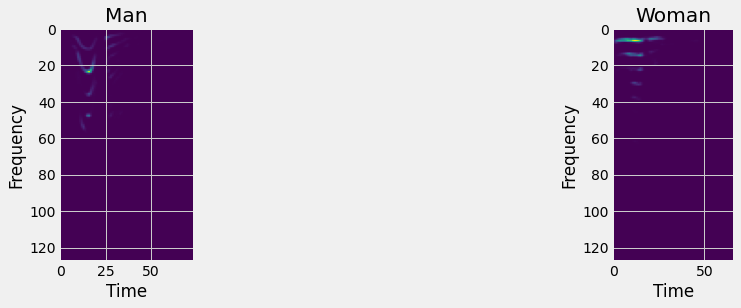

In [18]:
plt.figure(figsize=[16, 4])
plt.subplot(1, 2, 1)
plt.title("Man"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes1))

plt.subplot(1, 2, 2)
plt.title("Woman"); plt.xlabel("Time"); plt.ylabel("Frequency")
plt.imshow(get_melspectrogram(amplitudes2));

In [19]:
ref1 = librosa.feature.melspectrogram(amplitudes2, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

In [20]:
((ref1-get_melspectrogram(amplitudes2)) **2).mean()

6.153549085804041e-13

## Часть 2
Напишем простой классификатор биологического гендера спикера по мел спектрограмме. 
Сразу вопрос -- откуда возьмем данные?

In [21]:
!wget https://ndownloader.figshare.com/files/10256148

--2020-12-20 09:48:31--  https://ndownloader.figshare.com/files/10256148
Resolving ndownloader.figshare.com (ndownloader.figshare.com)... 52.16.75.60, 34.247.1.128, 18.202.203.7, ...
Connecting to ndownloader.figshare.com (ndownloader.figshare.com)|52.16.75.60|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip [following]
--2020-12-20 09:48:31--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/10256148/TIMIT.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.65.116
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.65.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 440207227 (420M) [binary/octet-stream]
Saving to: ‘10256148’

10256148            100%[===================>] 419.81M  99.9MB/s    in 4.3s    

2020-12-20 09:48:35 (96.9 MB/s) - ‘10256148’ saved [440207227/440207227]



In [22]:
!unzip -q 10256148

In [23]:
!pip install timit-utils

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5890 sha256=de209bf5adcec39b2ffb2352ac1f95c62b33dd1c7782e45b5ea931d92fa5bc01
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


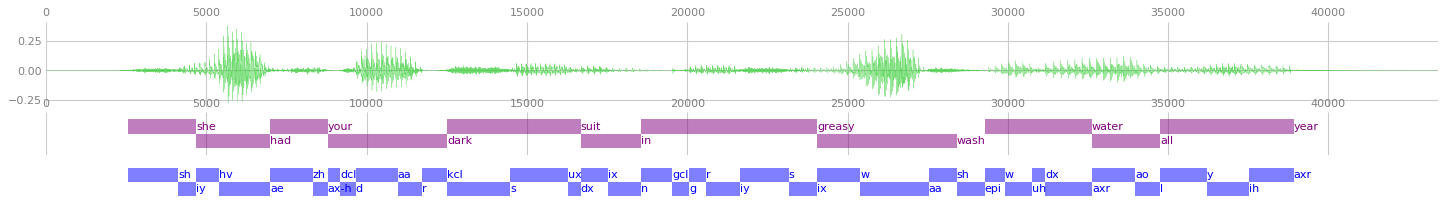

In [24]:
%matplotlib inline
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

DATA_PATH = 'data/lisa/data/timit/raw/TIMIT'
corpus = tu.Corpus(DATA_PATH)
sentence = corpus.train.sentences_by_phone_df('aa').sentence[0]
du.DrawVerticalPanels([du.AudioPanel(sentence.raw_audio, show_x_axis=True),
                       du.WordsPanel(sentence.words_df, sentence.raw_audio.shape[0], show_x_axis=True),
                       du.PhonesPanel(sentence.phones_df, sentence.raw_audio.shape[0])
                      ])
  

In [25]:
class Speaker:

  def __init__(self, data_path):
    self.doc_file_path = os.path.join(data_path, 'DOC','SPKRINFO.TXT')
    with open(self.doc_file_path) as f:
      self.id_sex_dict = dict([(tmp.split(' ')[0], tmp.split(' ')[2]) for tmp in f.readlines()[39:]])

  def return_sex(self, id):
    return self.id_sex_dict[id]

Speakers_info = Speaker(DATA_PATH)

In [26]:
person_1 = corpus.train.person_by_index(100)

In [27]:
person_1.name

'DPS0'

In [28]:
Speakers_info.return_sex(person_1.name)

'M'

In [29]:
IPython.display.Audio(person_1.sentence_by_index(1).raw_audio, rate=16000)

In [30]:
def preprocess_sample(amplitudes, gender, sr=16000, max_length=150):
    spectrogram = get_melspectrogram(amplitudes, sample_rate=sr)[:, :max_length]
    spectrogram = np.pad(spectrogram, [[0, 0], [0, max(0, max_length - spectrogram.shape[1])]], mode='constant')
    target = 0 if gender == 'F' else 1
    return np.float32(spectrogram), np.int64(target)
    
#tmp_1 = preprocess_sample(person_1.sentence_by_index(1).raw_audio, Speakers_info.return_sex(person_1.name))[0]
#tmp_2 = librosa.feature.melspectrogram(person_1.sentence_by_index(1).raw_audio, sr=sample_rate, n_mels=128, fmin=1, fmax=8192)
#assert np.allclose(get_melspectrogram(amplitudes2), ref1, rtol=1e-4, atol=1e-4)

Создадим тестсет и трейнсет из данных для `TIMIT` 

In [31]:
def create_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(person.sentence_by_index(i).raw_audio, target))
  return spectrograms_and_targets

In [32]:
trainset = create_dataset('train')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [33]:
X, y = map(np.stack, zip(*trainset))
X = X.transpose([0, 2, 1])  # to [batch, time, channels]

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [34]:
X_train.shape

(3000, 150, 128)

In [41]:
y_train.shape

(3000,)

In [37]:
import keras, keras.layers

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(None, 128)), 
    keras.layers.Conv1D(32, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.Conv1D(64, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.Conv1D(128, kernel_size=4), keras.layers.Activation('relu'),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(2, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, None, 32)          16416     
_________________________________________________________________
activation_3 (Activation)    (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
activation_4 (Activation)    (None, None, 64)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 128)         32896     
_________________________________________________________________
activation_5 (Activation)    (None, None, 128)         0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)              

In [42]:
model.compile('sgd', 'sparse_categorical_crossentropy',
          metrics = ['sparse_categorical_accuracy'])
model.fit(X_train, y_train, epochs=30) 

Epoch 1/30
94/94 [==============================] - 3s 26ms/step - loss: 0.6184 - sparse_categorical_accuracy: 0.6878
Epoch 2/30
94/94 [==============================] - 3s 27ms/step - loss: 0.6034 - sparse_categorical_accuracy: 0.6879
Epoch 3/30
94/94 [==============================] - 3s 27ms/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7047
Epoch 4/30
94/94 [==============================] - 2s 27ms/step - loss: 0.5586 - sparse_categorical_accuracy: 0.7082
Epoch 5/30
94/94 [==============================] - 2s 26ms/step - loss: 0.5404 - sparse_categorical_accuracy: 0.7054
Epoch 6/30
94/94 [==============================] - 3s 27ms/step - loss: 0.4975 - sparse_categorical_accuracy: 0.7325
Epoch 7/30
94/94 [==============================] - 2s 27ms/step - loss: 0.4455 - sparse_categorical_accuracy: 0.7751
Epoch 8/30
94/94 [==============================] - 3s 27ms/step - loss: 0.3984 - sparse_categorical_accuracy: 0.8101
Epoch 9/30
94/94 [==============================] - 2s 2

In [43]:
testset = create_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [44]:
len(X_test)

1500

In [45]:
y_pred = model.predict_classes(X_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [46]:
accuracy_score(y_pred, y_test)

0.9566666666666667

Простые идеи для улучшения классификатора (представим, что решаем задачу посложнее):
1. 1d or 2d convolutions + batchnorm
2. VGG-like, residual
3. Upper batch size
4. Data augmentation (background noise? jitter? freq?)
5. Denoising?

### Часть 3
усложняем себе жизнь -- добавим шумов в данные и посмотрим как получится

In [47]:
def spoil_with_noise(data, noise_factor=0.02):
    noise = np.random.normal(size=len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

In [48]:
test_wav = person_1.sentence_by_index(0).raw_audio

In [49]:
IPython.display.Audio(spoil_with_noise(person_1.sentence_by_index(0).raw_audio), rate=16000)

In [50]:
def spoil_dataset(mode='train'):
  assert mode in ['train','test']
  if mode == 'train':
    people = [corpus.train.person_by_index(i) for i in range(400)]
  if mode == 'test':
    people = [corpus.test.person_by_index(i) for i in range(150)]
  spectrograms_and_targets = []
  for person in tqdm_notebook(people): 
    target = Speakers_info.return_sex(person.name)
    for i in range(len(person.sentences)):
      spectrograms_and_targets.append(preprocess_sample(spoil_with_noise(person.sentence_by_index(i).raw_audio),target))
  return spectrograms_and_targets

In [51]:
def speed_change(data, speed_factor=0.5):
  return librosa.effects.time_stretch(data, speed_factor)

In [52]:
speed_change(test_wav)

array([2.88025191e-04, 3.31737815e-05, 3.34295764e-05, ...,
       5.61410107e-05, 6.70315673e-05, 5.99620969e-05])

In [53]:
testset = spoil_dataset('test')
X_test, y_test = map(np.stack, zip(*testset))
X_test = X_test.transpose([0, 2, 1])  # to [batch, time, channels]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [54]:
accuracy_score(model.predict_classes(X_test),y_test)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.82

In [55]:
@Nestyme
@nda
zueva.nn@phystech.edu

SyntaxError: ignored